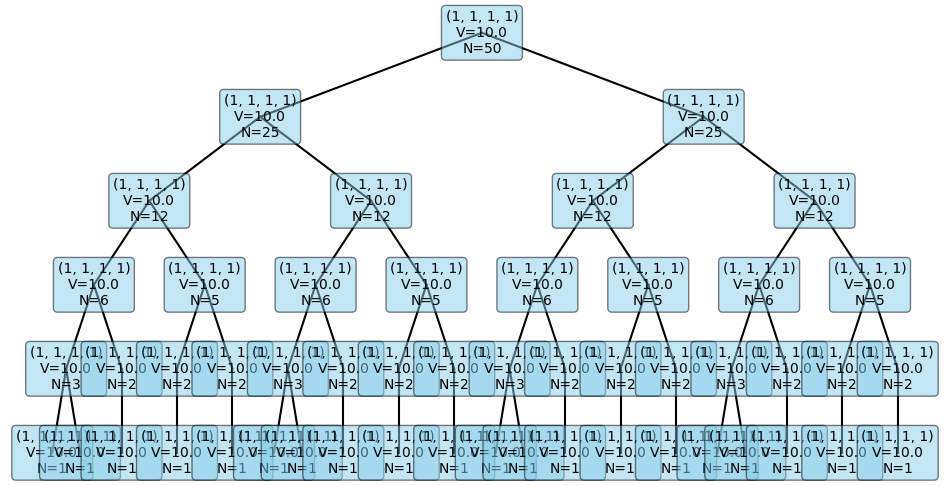

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import random

# ----------- Discretization -----------
def discretize(obs, bins=(3,3,3,3)):
    cart_pos, cart_vel, pole_angle, pole_vel = obs
    cart_pos_bin = int(np.clip(np.digitize(cart_pos, np.linspace(-2.4, 2.4, bins[0]-1)), 0, bins[0]-1))
    cart_vel_bin = int(np.clip(np.digitize(cart_vel, np.linspace(-3.0, 3.0, bins[1]-1)), 0, bins[1]-1))
    pole_angle_bin = int(np.clip(np.digitize(pole_angle, np.linspace(-0.21, 0.21, bins[2]-1)), 0, bins[2]-1))
    pole_vel_bin = int(np.clip(np.digitize(pole_vel, np.linspace(-3.0, 3.0, bins[3]-1)), 0, bins[3]-1))
    return (cart_pos_bin, cart_vel_bin, pole_angle_bin, pole_vel_bin)

# ----------- Simple CartPole Model for Simulation -----------
def simulate_step(state, action):
    # A very simplified model of CartPole transitions for MCTS
    cart_pos, cart_vel, pole_angle, pole_vel = state
    force = 1.0 if action == 1 else -1.0

    # Constants from CartPole environment
    dt = 0.02
    gravity = 9.8
    masscart = 1.0
    masspole = 0.1
    total_mass = masscart + masspole
    length = 0.5  # half pole length
    polemass_length = masspole * length

    # Equations of motion
    temp = (force + polemass_length * pole_vel**2 * np.sin(pole_angle)) / total_mass
    thetaacc = (gravity * np.sin(pole_angle) - np.cos(pole_angle) * temp) / (length * (4.0/3.0 - masspole * np.cos(pole_angle)**2 / total_mass))
    xacc = temp - polemass_length * thetaacc * np.cos(pole_angle) / total_mass

    # Update state
    cart_pos += cart_vel * dt
    cart_vel += xacc * dt
    pole_angle += pole_vel * dt
    pole_vel += thetaacc * dt

    # Check termination
    done = cart_pos < -2.4 or cart_pos > 2.4 or pole_angle < -0.21 or pole_angle > 0.21
    reward = 0 if done else 1

    return (cart_pos, cart_vel, pole_angle, pole_vel), reward, done

# ----------- Node Class -----------
class Node:
    def __init__(self, state, parent=None, action_from_parent=None):
        self.state = state
        self.parent = parent
        self.children = {}  # action: child node
        self.visits = 0
        self.total_reward = 0.0
        self.untried_actions = [0,1]
        self.action_from_parent = action_from_parent

    def q(self):
        return self.total_reward / self.visits if self.visits > 0 else 0

# ----------- UCB Function -----------
def ucb(node, child, c=1.4):
    if child.visits == 0:
        return float('inf')
    return child.q() + c * math.sqrt(math.log(node.visits) / child.visits)

# ----------- MCTS using Discrete Model -----------
def mcts_tree(root_state, iterations=50, rollout_depth=10):
    root = Node(root_state)

    for _ in range(iterations):
        node = root
        state = root_state

        # --------- Selection ---------
        while node.untried_actions == [] and node.children != {}:
            action, node = max(node.children.items(), key=lambda item: ucb(node, item[1]))
            state, reward, done = simulate_step(state, action)
            if done:
                break

        # --------- Expansion ---------
        if node.untried_actions != []:
            action = node.untried_actions.pop()
            next_state, reward, done = simulate_step(state, action)
            child_node = Node(next_state, parent=node, action_from_parent=action)
            node.children[action] = child_node
            node = child_node
            state = next_state

        # --------- Rollout ---------
        total_reward = 0
        rollout_state = state
        for _ in range(rollout_depth):
            action = random.choice([0,1])
            rollout_state, reward, done = simulate_step(rollout_state, action)
            total_reward += reward
            if done:
                break

        # --------- Backpropagation ---------
        while node is not None:
            node.visits += 1
            node.total_reward += total_reward
            node = node.parent

    return root

# ----------- Tree Visualization -----------
def draw_tree(node, x=0, y=0, dx=1, dy=-1, ax=None, level=0):
    if ax is None:
        fig, ax = plt.subplots(figsize=(12,6))
    ax.text(x, y, f"{discretize(node.state)}\nV={node.q():.1f}\nN={node.visits}", ha='center', va='center',
            bbox=dict(boxstyle="round,pad=0.3", facecolor='skyblue', alpha=0.5))
    num_children = len(node.children)
    if num_children > 0:
        step = dx / num_children
        start_x = x - dx/2 + step/2
        for i, child in enumerate(node.children.values()):
            child_x = start_x + i*step
            child_y = y + dy
            ax.plot([x, child_x], [y, child_y], 'k-')
            draw_tree(child, x=child_x, y=child_y, dx=dx/num_children, dy=dy, ax=ax, level=level+1)
    if level == 0:
        ax.axis('off')
        plt.show()

# ----------- Run MCTS and Draw Tree -----------
initial_state = (0.0, 0.0, 0.0, 0.0)  # start at center, pole upright
root = mcts_tree(initial_state, iterations=50, rollout_depth=10)
draw_tree(root)


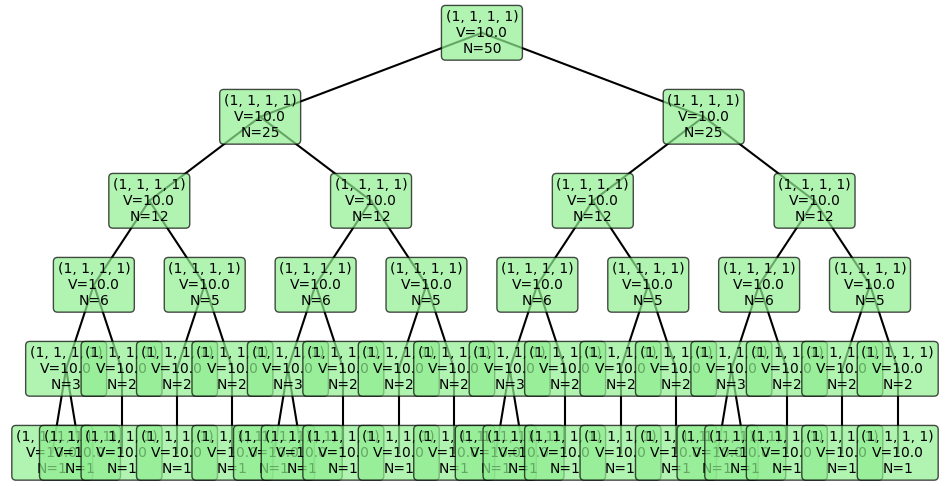

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import math
import random

# ----------- Discretization -----------
def discretize(obs, bins=(3,3,3,3)):
    cart_pos, cart_vel, pole_angle, pole_vel = obs
    cart_pos_bin = int(np.clip(np.digitize(cart_pos, np.linspace(-2.4, 2.4, bins[0]-1)), 0, bins[0]-1))
    cart_vel_bin = int(np.clip(np.digitize(cart_vel, np.linspace(-3.0, 3.0, bins[1]-1)), 0, bins[1]-1))
    pole_angle_bin = int(np.clip(np.digitize(pole_angle, np.linspace(-0.21, 0.21, bins[2]-1)), 0, bins[2]-1))
    pole_vel_bin = int(np.clip(np.digitize(pole_vel, np.linspace(-3.0, 3.0, bins[3]-1)), 0, bins[3]-1))
    return (cart_pos_bin, cart_vel_bin, pole_angle_bin, pole_vel_bin)

# ----------- Simple CartPole Model for Simulation -----------
def simulate_step(state, action):
    cart_pos, cart_vel, pole_angle, pole_vel = state
    force = 1.0 if action == 1 else -1.0

    dt = 0.02
    gravity = 9.8
    masscart = 1.0
    masspole = 0.1
    total_mass = masscart + masspole
    length = 0.5  # half pole length
    polemass_length = masspole * length

    temp = (force + polemass_length * pole_vel**2 * np.sin(pole_angle)) / total_mass
    thetaacc = (gravity * np.sin(pole_angle) - np.cos(pole_angle) * temp) / (length * (4.0/3.0 - masspole * np.cos(pole_angle)**2 / total_mass))
    xacc = temp - polemass_length * thetaacc * np.cos(pole_angle) / total_mass

    cart_pos += cart_vel * dt
    cart_vel += xacc * dt
    pole_angle += pole_vel * dt
    pole_vel += thetaacc * dt

    done = cart_pos < -2.4 or cart_pos > 2.4 or pole_angle < -0.21 or pole_angle > 0.21
    reward = 0 if done else 1

    return (cart_pos, cart_vel, pole_angle, pole_vel), reward, done

# ----------- Node Class -----------
class Node:
    def __init__(self, state, parent=None, action_from_parent=None):
        self.state = state
        self.parent = parent
        self.children = {}  # action: child node
        self.visits = 0
        self.total_reward = 0.0
        self.untried_actions = [0,1]
        self.action_from_parent = action_from_parent

    def q(self):
        return self.total_reward / self.visits if self.visits > 0 else 0

# ----------- UCB Function -----------
def ucb(node, child, c=1.4):
    if child.visits == 0:
        return float('inf')
    return child.q() + c * math.sqrt(math.log(node.visits) / child.visits)

# ----------- MCTS using Discrete Model -----------
def mcts_tree(root_state, iterations=50, rollout_depth=10):
    root = Node(root_state)

    for _ in range(iterations):
        node = root
        state = root_state

        # Selection
        while node.untried_actions == [] and node.children != {}:
            action, node = max(node.children.items(), key=lambda item: ucb(node, item[1]))
            state, reward, done = simulate_step(state, action)
            if done:
                break

        # Expansion
        if node.untried_actions != []:
            action = node.untried_actions.pop()
            next_state, reward, done = simulate_step(state, action)
            child_node = Node(next_state, parent=node, action_from_parent=action)
            node.children[action] = child_node
            node = child_node
            state = next_state

        # Rollout
        total_reward = 0
        rollout_state = state
        for _ in range(rollout_depth):
            action = random.choice([0,1])
            rollout_state, reward, done = simulate_step(rollout_state, action)
            total_reward += reward
            if done:
                break

        # Backpropagation
        while node is not None:
            node.visits += 1
            node.total_reward += total_reward
            node = node.parent

    return root

# ----------- Tree Visualization with Highlight -----------
def draw_tree_highlight(node, x=0, y=0, dx=1, dy=-1, ax=None, level=0):
    if ax is None:
        fig, ax = plt.subplots(figsize=(12,6))

    # Color based on q-value (reward)
    if node.visits > 0:
        if node.q() >= 8:
            color = 'lightgreen'  # promising
        else:
            color = 'salmon'      # risky
    else:
        color = 'skyblue'        # unexplored

    ax.text(x, y, f"{discretize(node.state)}\nV={node.q():.1f}\nN={node.visits}",
            ha='center', va='center',
            bbox=dict(boxstyle="round,pad=0.3", facecolor=color, alpha=0.7))

    num_children = len(node.children)
    if num_children > 0:
        step = dx / num_children
        start_x = x - dx/2 + step/2
        for i, child in enumerate(node.children.values()):
            child_x = start_x + i*step
            child_y = y + dy
            ax.plot([x, child_x], [y, child_y], 'k-')
            draw_tree_highlight(child, x=child_x, y=child_y, dx=dx/num_children, dy=dy, ax=ax, level=level+1)

    if level == 0:
        ax.axis('off')
        plt.show()

# ----------- Run MCTS and Draw Highlighted Tree -----------
initial_state = (0.0, 0.0, 0.0, 0.0)  # start at center, pole upright
root = mcts_tree(initial_state, iterations=50, rollout_depth=10)
draw_tree_highlight(root)


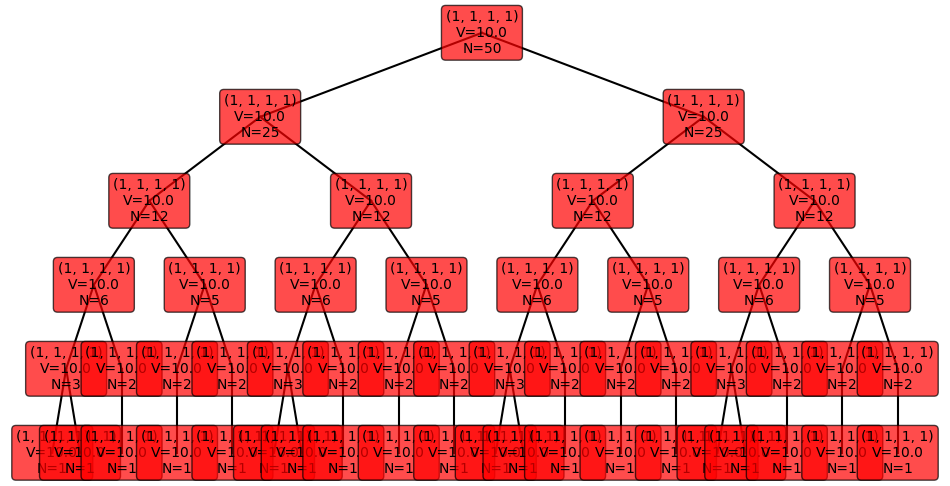

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import math
import random

# ----------- Discretization -----------
def discretize(obs, bins=(3,3,3,3)):
    cart_pos, cart_vel, pole_angle, pole_vel = obs
    cart_pos_bin = int(np.clip(np.digitize(cart_pos, np.linspace(-2.4, 2.4, bins[0]-1)), 0, bins[0]-1))
    cart_vel_bin = int(np.clip(np.digitize(cart_vel, np.linspace(-3.0, 3.0, bins[1]-1)), 0, bins[1]-1))
    pole_angle_bin = int(np.clip(np.digitize(pole_angle, np.linspace(-0.21, 0.21, bins[2]-1)), 0, bins[2]-1))
    pole_vel_bin = int(np.clip(np.digitize(pole_vel, np.linspace(-3.0, 3.0, bins[3]-1)), 0, bins[3]-1))
    return (cart_pos_bin, cart_vel_bin, pole_angle_bin, pole_vel_bin)

# ----------- Simple CartPole Model for Simulation -----------
def simulate_step(state, action):
    cart_pos, cart_vel, pole_angle, pole_vel = state
    force = 1.0 if action == 1 else -1.0

    dt = 0.02
    gravity = 9.8
    masscart = 1.0
    masspole = 0.1
    total_mass = masscart + masspole
    length = 0.5  # half pole length
    polemass_length = masspole * length

    temp = (force + polemass_length * pole_vel**2 * np.sin(pole_angle)) / total_mass
    thetaacc = (gravity * np.sin(pole_angle) - np.cos(pole_angle) * temp) / (length * (4.0/3.0 - masspole * np.cos(pole_angle)**2 / total_mass))
    xacc = temp - polemass_length * thetaacc * np.cos(pole_angle) / total_mass

    cart_pos += cart_vel * dt
    cart_vel += xacc * dt
    pole_angle += pole_vel * dt
    pole_vel += thetaacc * dt

    done = cart_pos < -2.4 or cart_pos > 2.4 or pole_angle < -0.21 or pole_angle > 0.21
    reward = 0 if done else 1

    return (cart_pos, cart_vel, pole_angle, pole_vel), reward, done

# ----------- Node Class -----------
class Node:
    def __init__(self, state, parent=None, action_from_parent=None):
        self.state = state
        self.parent = parent
        self.children = {}
        self.visits = 0
        self.total_reward = 0.0
        self.untried_actions = [0, 1]
        self.action_from_parent = action_from_parent

    def q(self):
        return self.total_reward / self.visits if self.visits > 0 else 0

# ----------- UCB Function -----------
def ucb(node, child, c=1.4):
    if child.visits == 0:
        return float('inf')
    return child.q() + c * math.sqrt(math.log(node.visits) / child.visits)

# ----------- MCTS using Discrete Model -----------
def mcts_tree(root_state, iterations=50, rollout_depth=10):
    root = Node(root_state)

    for _ in range(iterations):
        node = root
        state = root_state

        # Selection
        while node.untried_actions == [] and node.children != {}:
            action, node = max(node.children.items(), key=lambda item: ucb(node, item[1]))
            state, reward, done = simulate_step(state, action)
            if done:
                break

        # Expansion
        if node.untried_actions != []:
            action = node.untried_actions.pop()
            next_state, reward, done = simulate_step(state, action)
            child_node = Node(next_state, parent=node, action_from_parent=action)
            node.children[action] = child_node
            node = child_node
            state = next_state

        # Rollout
        total_reward = 0
        rollout_state = state
        for _ in range(rollout_depth):
            action = random.choice([0,1])
            rollout_state, reward, done = simulate_step(rollout_state, action)
            total_reward += reward
            if done:
                break

        # Backpropagation (dynamic update)
        while node is not None:
            node.visits += 1
            node.total_reward += total_reward
            node = node.parent

    return root

# ----------- Dynamic Tree Visualization -----------
def draw_tree_dynamic(node, x=0, y=0, dx=1, dy=-1, ax=None, level=0, q_min=None, q_max=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(12,6))

    # Compute tree-wide min/max q dynamically
    if q_min is None or q_max is None:
        all_q = []
        def collect_q(n):
            if n.visits > 0:
                all_q.append(n.q())
            for c in n.children.values():
                collect_q(c)
        collect_q(node)
        q_min = min(all_q) if all_q else 0
        q_max = max(all_q) if all_q else 1

    # Dynamic color based on relative q
    if node.visits > 0:
        norm = (node.q() - q_min) / (q_max - q_min + 1e-6)
        r = 1 - norm
        g = norm
        b = 0
        color = (r, g, b)
    else:
        color = 'skyblue'

    ax.text(x, y, f"{discretize(node.state)}\nV={node.q():.1f}\nN={node.visits}",
            ha='center', va='center',
            bbox=dict(boxstyle="round,pad=0.3", facecolor=color, alpha=0.7))

    num_children = len(node.children)
    if num_children > 0:
        step = dx / num_children
        start_x = x - dx/2 + step/2
        for i, child in enumerate(node.children.values()):
            child_x = start_x + i*step
            child_y = y + dy
            ax.plot([x, child_x], [y, child_y], 'k-')
            draw_tree_dynamic(child, x=child_x, y=child_y, dx=dx/num_children, dy=dy,
                              ax=ax, level=level+1, q_min=q_min, q_max=q_max)

    if level == 0:
        ax.axis('off')
        plt.show()

# ----------- Run MCTS and Draw Dynamic Tree -----------
initial_state = (0.0, 0.0, 0.0, 0.0)
rollout_depth = 10
root = mcts_tree(initial_state, iterations=50, rollout_depth=rollout_depth)
draw_tree_dynamic(root)


In [14]:
/?????????//////////////

Object `???????//////////////()` not found.


In [1]:
import gymnasium as gym
import numpy as np
import random
import networkx as nx
import matplotlib.pyplot as plt


class MCTSNode:
    def __init__(self, state, parent=None, action_taken=None):
        self.state = np.array(state, dtype=np.float32)
        self.parent = parent
        self.action_taken = action_taken
        self.children = {}  # action -> MCTSNode
        self.visits = 0
        self.value = 0.0  # total reward

    def is_leaf(self):
        return len(self.children) == 0

    def q_value(self):
        if self.visits == 0:
            return 0
        return self.value / self.visits


In [2]:
def rollout_from_state(base_state, first_action, max_steps=200):
    env_sim = gym.make("CartPole-v1")
    obs, info = env_sim.reset()
    env_sim.unwrapped.state = np.array(base_state, dtype=np.float32)
    total_reward = 0.0

    obs, reward, terminated, truncated, info = env_sim.step(first_action)
    total_reward += reward
    done = terminated or truncated
    steps = 1

    while not done and steps < max_steps:
        a = random.choice([0, 1])
        obs, reward, terminated, truncated, info = env_sim.step(a)
        total_reward += reward
        done = terminated or truncated
        steps += 1

    env_sim.close()
    return total_reward


In [3]:
def mcts(env, root_state, n_simulations=50, max_rollout_steps=200):
    root = MCTSNode(root_state)

    for _ in range(n_simulations):
        node = root
        path = [node]

        # === Selection: pick child with highest UCB1 ===
        while not node.is_leaf() and node.children:
            total_visits = sum(c.visits for c in node.children.values()) + 1
            best_score = -np.inf
            best_child = None
            for a, child in node.children.items():
                if child.visits == 0:
                    score = np.inf
                else:
                    # Upper Confidence Bound
                    score = child.q_value() + np.sqrt(2 * np.log(total_visits) / child.visits)
                if score > best_score:
                    best_score = score
                    best_child = child
            node = best_child
            path.append(node)

        # === Expansion: expand all actions if node is leaf ===
        if node.visits == 0:
            for action in [0, 1]:
                if action not in node.children:
                    node.children[action] = MCTSNode(
                        state=node.state, parent=node, action_taken=action
                    )

        # === Simulation: pick random child and rollout ===
        first_action = random.choice([0, 1])
        reward = rollout_from_state(node.state, first_action, max_steps=max_rollout_steps)

        # === Backpropagation ===
        for n in path:
            n.visits += 1
            n.value += reward

    # Compute policy (probability of taking each action from root)
    policy = {}
    for action, child in root.children.items():
        policy[action] = child.visits / root.visits

    # Return root for visualization
    return root, policy


In [4]:
def visualize_tree(root, depth=2):
    G = nx.DiGraph()
    labels = {}

    def add_node(node, parent_id=None, level=0):
        node_id = id(node)
        G.add_node(node_id)
        labels[node_id] = f"Val:{node.q_value():.1f}\nVis:{node.visits}"
        if parent_id:
            G.add_edge(parent_id, node_id, label=str(node.action_taken))
        if level < depth:
            for child in node.children.values():
                add_node(child, node_id, level + 1)

    add_node(root)
    pos = nx.spring_layout(G)
    plt.figure(figsize=(12, 8))
    nx.draw(G, pos, with_labels=True, labels=labels, node_size=2500, node_color="skyblue")
    edge_labels = nx.get_edge_attributes(G, "label")
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
    plt.show()


Policy (root node): {0: 0.02, 1: 0.96}


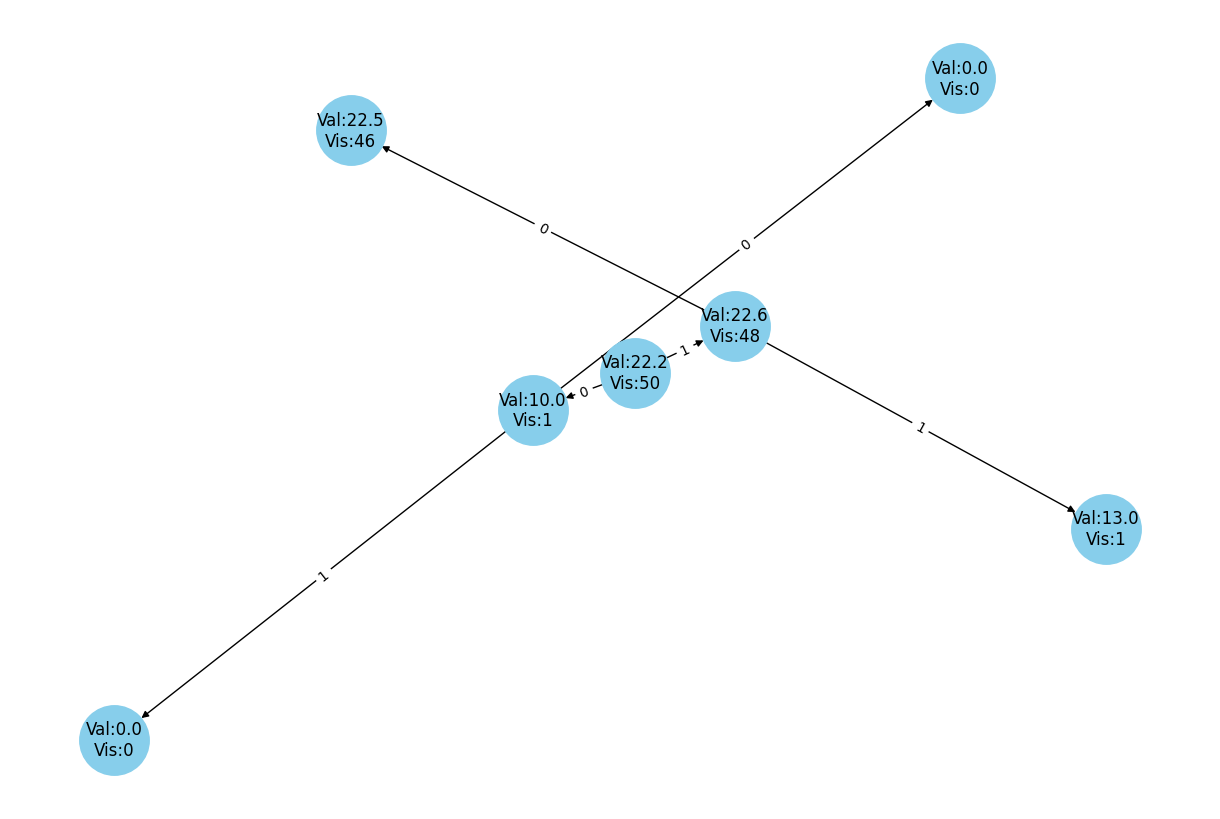

In [5]:
if __name__ == "__main__":
    env = gym.make("CartPole-v1")
    obs, info = env.reset()
    root_node, policy = mcts(env, env.unwrapped.state, n_simulations=50)
    print("Policy (root node):", policy)
    visualize_tree(root_node, depth=2)


In [5]:
# Real Code

Policy at root: {0: 0.96, 1: 0.02}

MCTS Tree Values:
- Action:None | Q=21.78, V=50
  - Action:0 | Q=21.92, V=48
    - Action:0 | Q=14.00, V=1
      - Action:0 | Q=0.00, V=0
      - Action:1 | Q=0.00, V=0
    - Action:1 | Q=22.30, V=46
      - Action:0 | Q=19.67, V=3
      - Action:1 | Q=22.52, V=42
  - Action:1 | Q=11.00, V=1
    - Action:0 | Q=0.00, V=0
    - Action:1 | Q=0.00, V=0


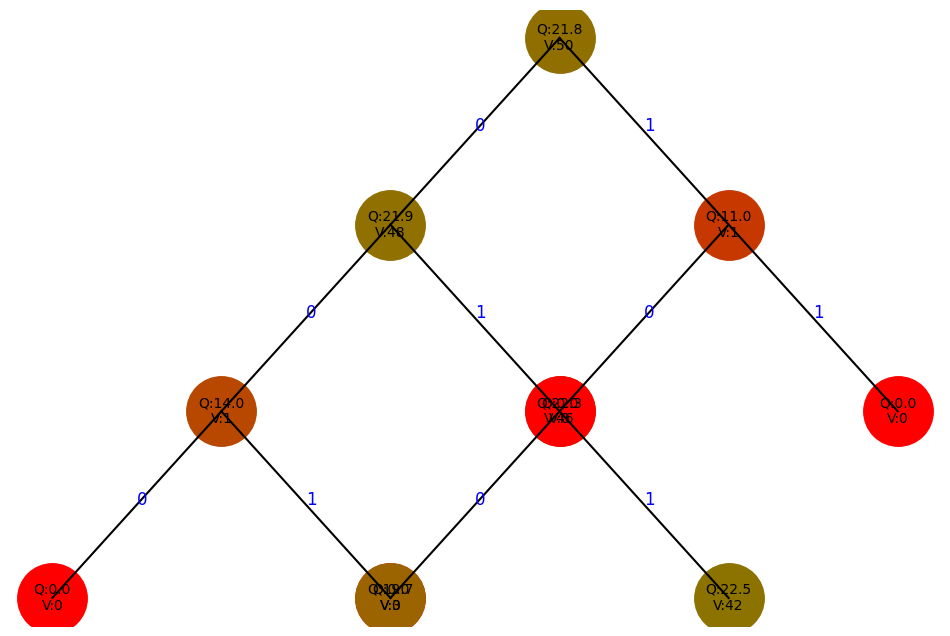

In [4]:
import gymnasium as gym
import numpy as np
import random
import matplotlib.pyplot as plt

# ---------------- MCTS Node ----------------
class MCTSNode:
    def __init__(self, state, parent=None, action_taken=None):
        self.state = np.array(state, dtype=np.float32)
        self.parent = parent
        self.action_taken = action_taken
        self.children = {}  # action -> child node
        self.visits = 0
        self.value = 0.0

    def is_leaf(self):
        return len(self.children) == 0

    def q_value(self):
        return self.value / self.visits if self.visits > 0 else 0

# ---------------- Rollout ----------------
def rollout_from_state(base_state, first_action, max_steps=200):
    env_sim = gym.make("CartPole-v1")
    obs, info = env_sim.reset()
    env_sim.unwrapped.state = np.array(base_state, dtype=np.float32)

    total_reward = 0.0
    obs, reward, terminated, truncated, info = env_sim.step(first_action)
    total_reward += reward
    done = terminated or truncated
    steps = 1

    while not done and steps < max_steps:
        a = random.choice([0, 1])
        obs, reward, terminated, truncated, info = env_sim.step(a)
        total_reward += reward
        done = terminated or truncated
        steps += 1

    env_sim.close()
    return total_reward

# ---------------- MCTS Algorithm ----------------
def mcts(env, root_state, n_simulations=50, max_rollout_steps=200):
    root = MCTSNode(root_state)

    for _ in range(n_simulations):
        node = root
        path = [node]

        # --- Selection ---
        while not node.is_leaf() and node.children:
            total_visits = sum(c.visits for c in node.children.values()) + 1
            best_score = -np.inf
            best_child = None
            for a, child in node.children.items():
                if child.visits == 0:
                    score = np.inf
                else:
                    score = child.q_value() + np.sqrt(2 * np.log(total_visits) / child.visits)
                if score > best_score:
                    best_score = score
                    best_child = child
            node = best_child
            path.append(node)

        # --- Expansion ---
        if node.visits == 0:
            for action in [0, 1]:
                if action not in node.children:
                    node.children[action] = MCTSNode(state=node.state, parent=node, action_taken=action)

        # --- Simulation ---
        first_action = random.choice([0, 1])
        reward = rollout_from_state(node.state, first_action, max_steps=max_rollout_steps)

        # --- Backpropagation ---
        for n in path:
            n.visits += 1
            n.value += reward

    # Policy at root
    policy = {action: child.visits / root.visits for action, child in root.children.items()}
    return root, policy

# ---------------- Print Tree ----------------
def print_tree(node, depth=0, max_depth=3):
    if depth > max_depth:
        return
    indent = "  " * depth
    print(f"{indent}- Action:{node.action_taken} | Q={node.q_value():.2f}, V={node.visits}")
    for child in node.children.values():
        print_tree(child, depth + 1, max_depth)

# ---------------- Tree Visualization (Matplotlib) ----------------
def visualize_tree_matplotlib(root, max_depth=3):
    fig, ax = plt.subplots(figsize=(12, 8))

    positions = {}
    labels = {}
    colors = []

    def add_node(node, x, y, level=0):
        node_id = id(node)
        positions[node_id] = (x, y)
        labels[node_id] = f"Q:{node.q_value():.1f}\nV:{node.visits}"
        normalized = min(max(node.q_value() / 50, 0), 1)
        colors.append((1 - normalized, normalized, 0))  # Red -> Green

        # Draw edges to children
        if level < max_depth and node.children:
            n_children = len(node.children)
            dx = 1 / (n_children + 1)
            i = 1
            for child in node.children.values():
                child_x = x - 0.5 + i * dx
                child_y = y - 1
                ax.plot([x, child_x], [y, child_y], 'k-')
                # Add edge label (action)
                mid_x = (x + child_x) / 2
                mid_y = (y + child_y) / 2
                ax.text(mid_x, mid_y, str(child.action_taken), color='blue', fontsize=12)
                add_node(child, child_x, child_y, level + 1)
                i += 1

    add_node(root, 0, 0)

    # Draw nodes
    for node_id, (x, y) in positions.items():
        ax.scatter(x, y, s=2500, c=[colors[list(positions.keys()).index(node_id)]])
        ax.text(x, y, labels[node_id], ha='center', va='center', fontsize=10)

    ax.axis('off')
    plt.show()

# ---------------- Run Example ----------------
if __name__ == "__main__":
    env = gym.make("CartPole-v1")
    obs, info = env.reset()
    root_node, policy = mcts(env, env.unwrapped.state, n_simulations=50)

    print("Policy at root:", policy)
    print("\nMCTS Tree Values:")
    print_tree(root_node, max_depth=3)

    visualize_tree_matplotlib(root_node, max_depth=3)


Policy at root: {0: 0.02, 1: 0.96}

MCTS Tree with Q, V and Per-node Policy:

- Action:None | Q=23.76, V=50
    Policy(a=0) = 0.02
    Policy(a=1) = 0.96
  - Action:0 | Q=11.00, V=1
      Policy(a=0) = 0.00
      Policy(a=1) = 0.00
    - Action:0 | Q=0.00, V=0
    - Action:1 | Q=0.00, V=0
  - Action:1 | Q=24.04, V=48
      Policy(a=0) = 0.85
      Policy(a=1) = 0.12
    - Action:0 | Q=24.66, V=41
        Policy(a=0) = 0.95
        Policy(a=1) = 0.02
      - Action:0 | Q=25.15, V=39
          Policy(a=0) = 0.95
          Policy(a=1) = 0.03
      - Action:1 | Q=9.00, V=1
          Policy(a=0) = 0.00
          Policy(a=1) = 0.00
    - Action:1 | Q=16.33, V=6
        Policy(a=0) = 0.67
        Policy(a=1) = 0.17
      - Action:0 | Q=14.50, V=4
          Policy(a=0) = 0.25
          Policy(a=1) = 0.50
      - Action:1 | Q=12.00, V=1
          Policy(a=0) = 0.00
          Policy(a=1) = 0.00


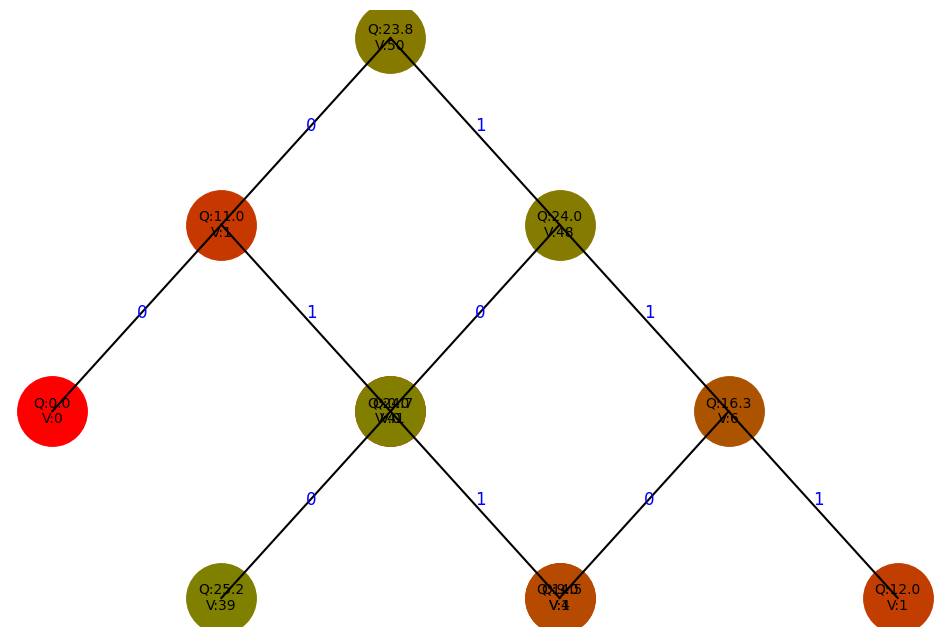

In [12]:
import gymnasium as gym
import numpy as np
import random
import matplotlib.pyplot as plt

# ---------------- MCTS Node ----------------
class MCTSNode:
    def __init__(self, state, parent=None, action_taken=None):
        self.state = np.array(state, dtype=np.float32)
        self.parent = parent
        self.action_taken = action_taken
        self.children = {}  # action -> child node
        self.visits = 0
        self.value = 0.0

    def is_leaf(self):
        return len(self.children) == 0

    def q_value(self):
        return self.value / self.visits if self.visits > 0 else 0


# ---------------- Rollout ----------------
def rollout_from_state(base_state, first_action, max_steps=200):
    env_sim = gym.make("CartPole-v1")
    obs, info = env_sim.reset()
    env_sim.unwrapped.state = np.array(base_state, dtype=np.float32)

    total_reward = 0.0
    obs, reward, terminated, truncated, info = env_sim.step(first_action)
    total_reward += reward
    done = terminated or truncated
    steps = 1

    while not done and steps < max_steps:
        a = random.choice([0, 1])
        obs, reward, terminated, truncated, info = env_sim.step(a)
        total_reward += reward
        done = terminated or truncated
        steps += 1

    env_sim.close()
    return total_reward


# ---------------- MCTS Algorithm ----------------
def mcts(env, root_state, n_simulations=50, max_rollout_steps=200):
    root = MCTSNode(root_state)

    for _ in range(n_simulations):
        node = root
        path = [node]

        # --- Selection ---
        while not node.is_leaf() and node.children:
            total_visits = sum(c.visits for c in node.children.values()) + 1
            best_score = -np.inf
            best_child = None
            for child in node.children.values():
                if child.visits == 0:
                    score = np.inf
                else:
                    score = child.q_value() + np.sqrt(2 * np.log(total_visits) / child.visits)
                if score > best_score:
                    best_score = score
                    best_child = child
            node = best_child
            path.append(node)

        # --- Expansion ---
        if node.visits == 0:
            for action in [0, 1]:
                if action not in node.children:
                    node.children[action] = MCTSNode(
                        state=node.state,
                        parent=node,
                        action_taken=action
                    )

        # --- Simulation ---
        first_action = random.choice([0, 1])
        reward = rollout_from_state(node.state, first_action, max_steps=max_rollout_steps)

        # --- Backpropagation ---
        for n in path:
            n.visits += 1
            n.value += reward

    # Root policy
    policy = {a: c.visits / root.visits for a, c in root.children.items()}
    return root, policy


# ---------------- Per-node Policy ----------------
def node_policy(node):
    if node.visits == 0:
        return {}
    return {a: c.visits / node.visits for a, c in node.children.items()}


# ---------------- Print Tree (Q + V + Policy) ----------------
def print_tree(node, depth=0, max_depth=3):
    if depth > max_depth:
        return

    indent = "  " * depth
    print(f"{indent}- Action:{node.action_taken} | Q={node.q_value():.2f}, V={node.visits}")

    policy = node_policy(node)
    for a, p in policy.items():
        print(f"{indent}    Policy(a={a}) = {p:.2f}")

    for child in node.children.values():
        print_tree(child, depth + 1, max_depth)


# ---------------- Tree Visualization (Matplotlib) ----------------
def visualize_tree_matplotlib(root, max_depth=3):
    fig, ax = plt.subplots(figsize=(12, 8))
    positions = {}
    labels = {}
    colors = []

    def add_node(node, x, y, level=0):
        node_id = id(node)
        positions[node_id] = (x, y)
        labels[node_id] = f"Q:{node.q_value():.1f}\nV:{node.visits}"

        normalized = min(max(node.q_value() / 50, 0), 1)
        colors.append((1 - normalized, normalized, 0))

        if level < max_depth and node.children:
            dx = 1 / (len(node.children) + 1)
            i = 1
            for child in node.children.values():
                cx = x - 0.5 + i * dx
                cy = y - 1
                ax.plot([x, cx], [y, cy], 'k-')
                ax.text((x + cx)/2, (y + cy)/2, str(child.action_taken),
                        color='blue', fontsize=12)
                add_node(child, cx, cy, level + 1)
                i += 1

    add_node(root, 0, 0)

    for idx, (node_id, (x, y)) in enumerate(positions.items()):
        ax.scatter(x, y, s=2500, c=[colors[idx]])
        ax.text(x, y, labels[node_id], ha='center', va='center', fontsize=10)

    ax.axis('off')
    plt.show()


# ---------------- Run Example ----------------
if __name__ == "__main__":
    env = gym.make("CartPole-v1")
    obs, info = env.reset()

    root_node, policy = mcts(env, env.unwrapped.state, n_simulations=50)

    print("Policy at root:", policy)
    print("\nMCTS Tree with Q, V and Per-node Policy:\n")
    print_tree(root_node, max_depth=3)

    visualize_tree_matplotlib(root_node, max_depth=3)
